In [1]:
!pip install transformers datasets tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

from numpy import random

import tensorflow_datasets as tfds 
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,InputLayer,BatchNormalization,
                                     Dropout,Input,LayerNormalization)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

In [6]:
BATCH_SIZE=8

In [7]:
dataset_id='imdb'
dataset = load_dataset(dataset_id) # load_dataset is a function of datasets library of HuggingFace

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [9]:
import pandas as pd
pd.DataFrame({'text':dataset['train'][:5]['text'],'label':dataset['train'][:5]['label']})

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [10]:
model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
test_input_1='The Weather of Today is Gréat! zwp'
test_input_2='How are you doing?'
inputs=[test_input_1,test_input_2]

tokenizer.tokenize(inputs)

['the',
 'weather',
 'of',
 'today',
 'is',
 'great',
 '!',
 'z',
 '##w',
 '##p',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [12]:
output=tokenizer(inputs,padding=True,truncation=True,max_length=128)
print(output)

{'input_ids': [[101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 1062, 2860, 2361, 102], [101, 2129, 2024, 2017, 2725, 1029, 102, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [14]:
tokenizer.decode(output['input_ids'][1])

'[CLS] how are you doing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [15]:
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [16]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [17]:
pd.DataFrame({
    'text':tokenized_dataset['train'][:5]['text'],
    'label':tokenized_dataset['train'][:5]['label'],
    'input_ids':tokenized_dataset['train'][:5]['input_ids'],
    'token_type_ids':tokenized_dataset['train'][:5]['token_type_ids'],
    'attention_mask':tokenized_dataset['train'][:5]['attention_mask']
    })

,text,label,input_ids,token_type_ids,attention_mask
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,"[101, 1045, 12524, 1045, 2572, 8025, 1011, 375...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"[101, 1000, 1045, 2572, 8025, 1024, 3756, 1000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,If only to avoid making this type of film in t...,0,"[101, 2065, 2069, 2000, 4468, 2437, 2023, 2828...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,This film was probably inspired by Godard's Ma...,0,"[101, 2023, 2143, 2001, 2763, 4427, 2011, 2643...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Oh, brother...after hearing about this ridicul...",0,"[101, 2821, 1010, 2567, 1012, 1012, 1012, 2044...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [18]:
# Train Dataset

tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [19]:
# Test Dataset

tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [20]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [21]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [22]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[  101,  2034,  1010, ...,  2149,  1006,   102],
       [  101, 27594,  2121, ...,     0,     0,     0],
       [  101,  4369,  9686, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2018, ...,     0,     0,     0],
       [  101,  1045,  3427, ...,     0,     0,     0],
       [  101,  1999,  3301, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

In [23]:
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [25]:
# Optimizer
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [27]:
history=model.fit(
    tf_train_dataset.take(1000),
    validation_data=tf_val_dataset,
    epochs=3)

Epoch 1/3
1000/1000 [==============================] - 2168s 2s/step - loss: 0.6939 - accuracy: 0.5729 - val_loss: 0.6786 - val_accuracy: 0.6902
Epoch 2/3
1000/1000 [==============================] - 2123s 2s/step - loss: 0.6279 - accuracy: 0.6472 - val_loss: 0.5926 - val_accuracy: 0.7384
Epoch 3/3
1000/1000 [==============================] - 2143s 2s/step - loss: 0.4314 - accuracy: 0.8590 - val_loss: 0.3180 - val_accuracy: 0.8984


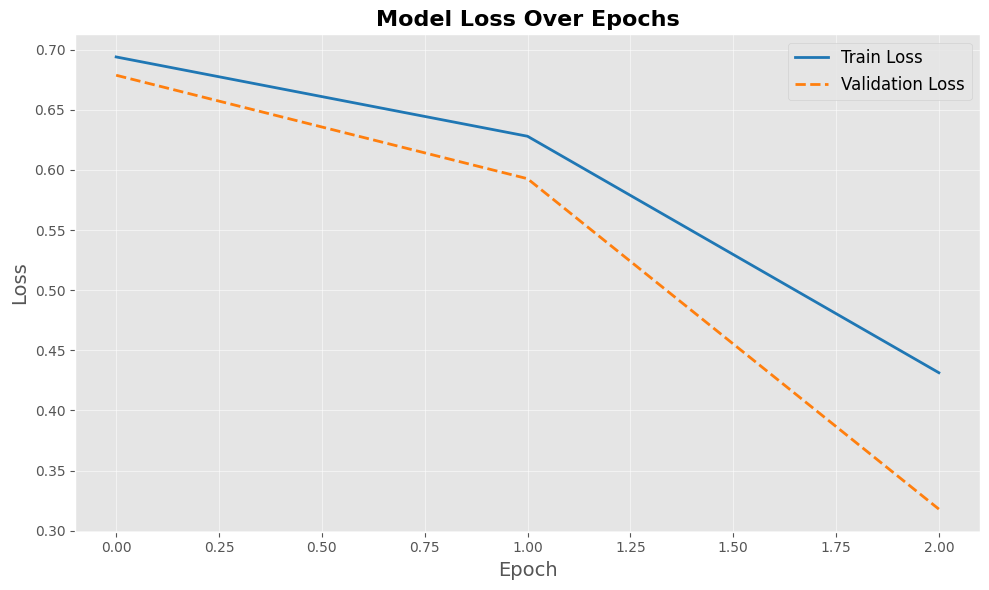

In [34]:

plt.style.use('ggplot')


train_color = '#1f77b4'  # Blue
val_color = '#ff7f0e'    # Orange


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color=train_color, linewidth=2, label='Train Loss')
plt.plot(history.history['val_loss'], color=val_color, linewidth=2, linestyle='--', label='Validation Loss')


plt.title('Model Loss Over Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)


plt.legend(loc='upper right', fontsize=12)


plt.grid(alpha=0.5)


plt.tight_layout()
plt.show()


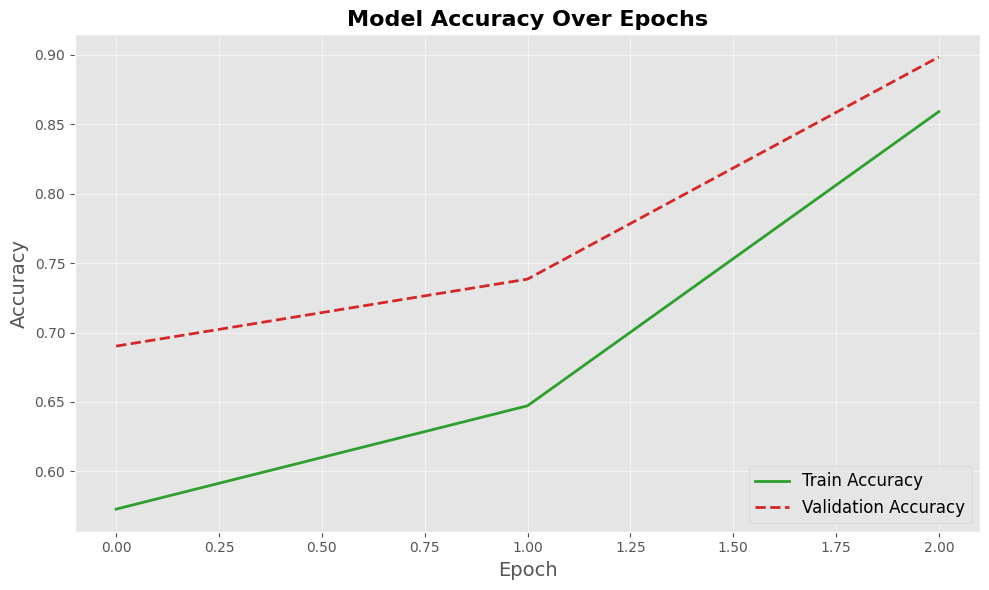

In [35]:
import matplotlib.pyplot as plt


plt.style.use('ggplot')


train_color = '#2ca02c'  # Green
val_color = '#d62728'    # Red


plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], color=train_color, linewidth=2, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color=val_color, linewidth=2, linestyle='--', label='Validation Accuracy')


plt.title('Model Accuracy Over Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)


plt.legend(loc='lower right', fontsize=12)


plt.grid(alpha=0.5)


plt.tight_layout()
plt.show()


In [30]:
inputs = tokenizer(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "], padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[1.0970045]
 [0.4739532]], shape=(2, 1), dtype=float32)


In [31]:
# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis=-1)

# Print the probabilities
print(probabilities)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
